cluster=0 데이터 개수: 174
Removed outliers: (44, 81)

■ 회귀 계수
    변수           계수
 const 32823.354951
   매출액 27435.418352
1인당순이익   893.229124

■ statsmodels OLS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     52.72
Date:                Mon, 19 May 2025   Prob (F-statistic):           2.09e-16
Time:                        15:17:34   Log-Likelihood:                -1118.8
No. Observations:                 104   AIC:                             2244.
Df Residuals:                     101   BIC:                             2251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t  

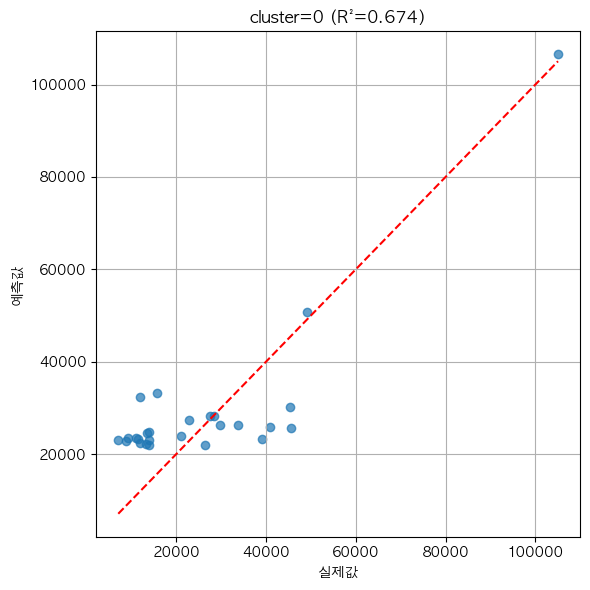

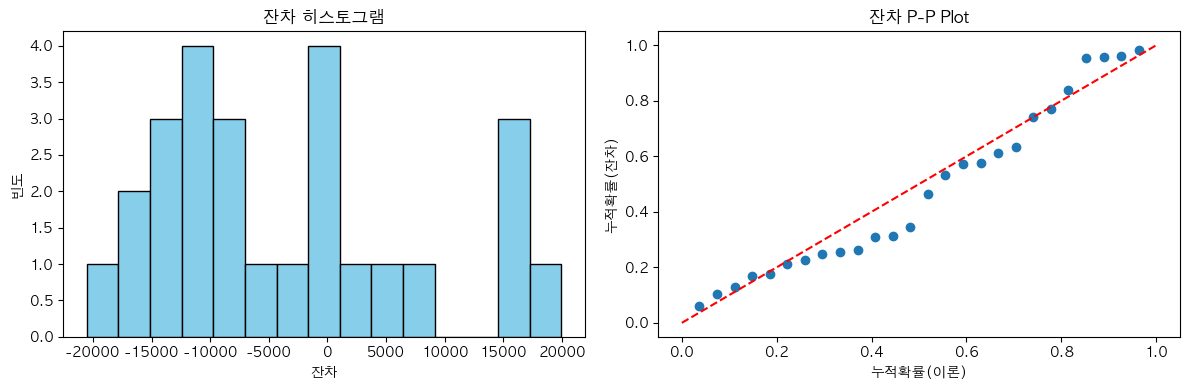

In [2]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 0. 설정
file_path      = "../연관분석/입주공장_면적x평당매매가추가_output.xlsx"
input_cols     = ['매출액', '1인당순이익']
target_col     = '면적 * 평당매매가'
min_obs        = 20
r2_thresh      = 0.65
shapiro_thresh = 0.01
bp_thresh      = 0.01

# 1. 데이터 로드 & 정제
df = pd.read_excel(file_path, engine="openpyxl")
for col in input_cols + [target_col]:
    s = df[col].astype(str).str.replace(r"[^0-9\.-]+", "", regex=True)
    s = s.str.replace(r"^[-\.]+$", "", regex=True).replace("", np.nan)
    df[col] = pd.to_numeric(s, errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=input_cols + [target_col])

# 2. cluster==0인 데이터만 선택
if 'cluster' not in df.columns:
    raise ValueError("데이터프레임에 'cluster' 컬럼이 없습니다.")

df_cluster0 = df[df['cluster'] == 0].copy()
print(f"cluster=0 데이터 개수: {len(df_cluster0)}")
if len(df_cluster0) < min_obs:
    raise ValueError(f"cluster=0 데이터가 {min_obs}개 미만입니다.")

# 3. 스케일링
scaler = StandardScaler()
X_all = scaler.fit_transform(df_cluster0[input_cols])
y_all = df_cluster0[target_col].values

# 4. 이상치 순차 제거
removed = pd.DataFrame(columns=df_cluster0.columns)
current_df = df_cluster0.copy()
current_X = X_all.copy()
current_y = y_all.copy()

while len(current_df) > min_obs:
    X_tr, X_te, y_tr, y_te = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    resid = y_te - y_pred
    _, p_shapiro = stats.shapiro(resid)
    X_te_sm = sm.add_constant(X_te)
    _, p_bp, _, _ = het_breuschpagan(resid, X_te_sm)
    if r2 >= r2_thresh and p_shapiro >= shapiro_thresh and p_bp >= bp_thresh:
        break
    full_pred = model.predict(current_X)
    full_resid = np.abs(current_y - full_pred)
    worst_i = full_resid.argmax()
    worst_idx = current_df.index[worst_i]
    removed = pd.concat([removed, current_df.loc[[worst_idx]]], ignore_index=True)
    current_df = current_df.drop(index=worst_idx)
    current_X = np.delete(current_X, worst_i, axis=0)
    current_y = np.delete(current_y, worst_i, axis=0)

# 5. 제거된 이상치 저장 (옵션)
removed.to_csv("removed_until_diagnostics_cluster0.csv", index=False)
print("Removed outliers:", removed.shape)

# 6. 최종 학습/검증
X_train, X_test, y_train, y_test = train_test_split(current_X, current_y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# 7. 회귀 계수 출력
coef_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    '계수': np.concatenate(([model.intercept_], model.coef_))
})
print("\n■ 회귀 계수")
print(coef_df.to_string(index=False))

# 8. statsmodels OLS 상세 분석
X_tr_sm = sm.add_constant(X_train)
X_te_sm = sm.add_constant(X_test)
ols_sm = sm.OLS(y_train, X_tr_sm).fit()
print("\n■ statsmodels OLS Summary")
print(ols_sm.summary())

# 9. VIF 계산
vif_df = pd.DataFrame({
    '변수': ['const'] + input_cols,
    'VIF': [variance_inflation_factor(np.column_stack((np.ones(len(X_train)), X_train)), i)
            for i in range(X_train.shape[1]+1)]
})
print("\n■ VIF (다중공선성 지수)")
print(vif_df.to_string(index=False))

# 10. 주요 진단 통계량
r2_val = r2_score(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
resid_test = y_test - y_pred

print(f"\n■ 주요 성능 지표\n R²: {r2_val:.4f}\n RMSE: {rmse_val:.2f}")
print(f" Shapiro–Wilk p-value: {stats.shapiro(resid_test)[1]:.4f}")
bp = het_breuschpagan(resid_test, X_te_sm)
print(f" Breusch–Pagan p-value: {bp[1]:.4f}")
print(f" Durbin–Watson stat: {durbin_watson(resid_test):.4f}")

# 11. 산점도: 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값"); plt.ylabel("예측값")
plt.title(f"cluster=0 (R²={r2_val:.3f})")
plt.grid(True); plt.tight_layout()
plt.show()

# 12. 잔차 히스토그램 & P-P plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(resid_test, bins=15, color='skyblue', edgecolor='k')
axes[0].set_title("잔차 히스토그램")
axes[0].set_xlabel("잔차")
axes[0].set_ylabel("빈도")
resid_sorted = np.sort(resid_test)
n = len(resid_sorted)
probs = np.arange(1, n+1) / (n+1)
theoretical = stats.norm.cdf(resid_sorted, loc=np.mean(resid_test), scale=np.std(resid_test))
axes[1].plot(probs, theoretical, 'o', label='잔차 P-P')
axes[1].plot([0,1], [0,1], 'r--')
axes[1].set_title("잔차 P-P Plot")
axes[1].set_xlabel("누적확률(이론)")
axes[1].set_ylabel("누적확률(잔차)")
plt.tight_layout()
plt.show()